In [1]:
from PIL import Image
import numpy as np
import potrace
import cv2

import multiprocessing
from time import time
import os
import sys
import getopt
import traceback

COLOUR = '#2464b4' # Hex value of colour for graph output
BILATERAL_FILTER = False # Reduce number of lines with bilateral filter
USE_L2_GRADIENT = False # Creates less edges but is still accurate (leads to faster renders)

In [2]:
def get_trace(data):
    for i in range(len(data)):
        data[i][data[i] > 1] = 1
    bmp = potrace.Bitmap(data)
    path = bmp.trace(2, potrace.TURNPOLICY_MINORITY, 1.0, 1, .5)
    return path


def get_latex(filename):
    latex = []
    path = get_trace(get_contours(filename))
    curves_list = list()
    for curve in path.curves:
        segments = curve.segments
        start = curve.start_point
        for segment in segments:
            x0, y0 = start
            if segment.is_corner:
                x1, y1 = segment.c
                x2, y2 = segment.end_point
                latex.append('((1-t)%f+t%f,(1-t)%f+t%f)' % (x0, x1, y0, y1))
                latex.append('((1-t)%f+t%f,(1-t)%f+t%f)' % (x1, x2, y1, y2))
                curves_list.append(((x0, y0), (x1, y1), (x2, y2), (x0, y0)))

            else:
                x1, y1 = segment.c1
                x2, y2 = segment.c2
                x3, y3 = segment.end_point
                curves_list.append(((x0, y0), (x1, y1), (x2, y2), (x3, y3)))
                latex.append('((1-t)((1-t)((1-t)%f+t%f)+t((1-t)%f+t%f))+t((1-t)((1-t)%f+t%f)+t((1-t)%f+t%f)),\
                (1-t)((1-t)((1-t)%f+t%f)+t((1-t)%f+t%f))+t((1-t)((1-t)%f+t%f)+t((1-t)%f+t%f)))' % \
                (x0, x1, x1, x2, x1, x2, x2, x3, y0, y1, y1, y2, y1, y2, y2, y3))
            start = segment.end_point
    return curves_list

def get_contours(image, nudge = .33):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if BILATERAL_FILTER:
        median = max(10, min(245, np.median(gray)))
        lower = int(max(0, (1 - nudge) * median))
        upper = int(min(255, (1 + nudge) * median))
        filtered = cv2.bilateralFilter(gray, 5, 50, 50)
        edged = cv2.Canny(filtered, lower, upper, L2gradient = USE_L2_GRADIENT)
    else:
        edged = cv2.Canny(gray, 30, 200)

    return edged[::-1]

In [3]:
curves = get_latex("img.png")

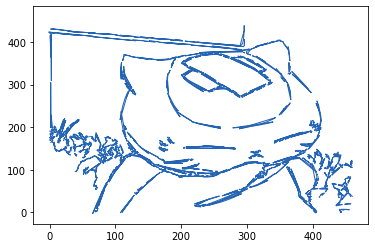

<Figure size 1440x1440 with 0 Axes>

In [4]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

Path = mpath.Path
fig, ax = plt.subplots()

patch_list = list()
for curve in curves:
    pp = mpatches.PathPatch(
    Path(curve,[Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CLOSEPOLY]),
    fc="none", transform=ax.transData, color=COLOUR)
    ax.add_patch(pp)
    ax.plot([0], [0])

plt.figure(figsize=(20,20))
plt.show()